# Corrélations non linéaires

Les corrélations indiquent si deux variables sont linéairement équivalentes. Comment étendre cette notion à des variables liées mais pas de façon linéaire.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [3]:
%matplotlib inline

## Un exemple

In [4]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
Y = iris.target
import pandas
df = pandas.DataFrame(X)
df.columns = ["X1", "X2", "X3", "X4"]
df.head()

,X1,X2,X3,X4
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


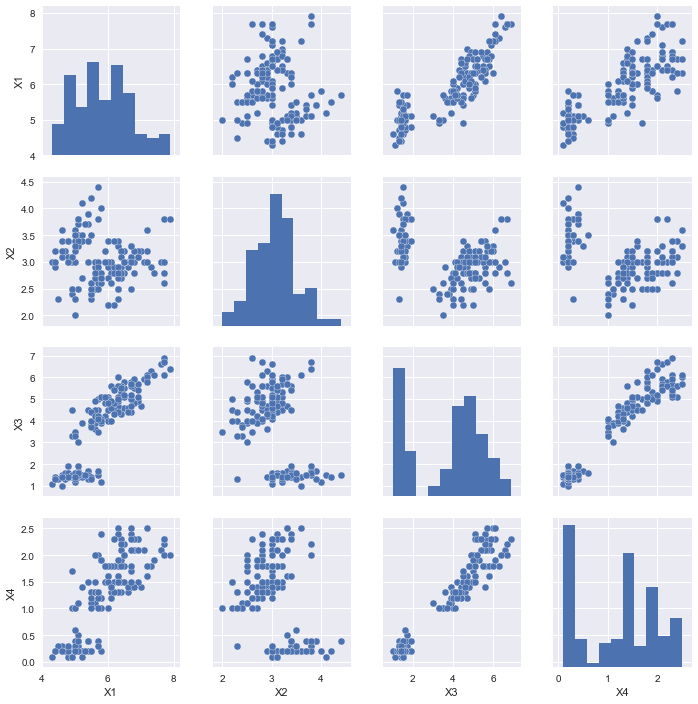

In [6]:
import seaborn as sns
sns.set()
sns.pairplot(df)

Et les corrélations :

In [8]:
df.corr()

,X1,X2,X3,X4
X1,1.000000,-0.109369,0.871754,0.817954
X2,-0.109369,1.000000,-0.420516,-0.356544
X3,0.871754,-0.420516,1.000000,0.962757
X4,0.817954,-0.356544,0.962757,1.000000


## Un peu de théorie

Le coefficient de [corrélation](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)) de Pearson est calculé comme suit :

$$cor(X_i, X_j) = \frac{cov(X_i, Y_i)}{\sigma(X_i)\sigma(X_j)}$$

Lorsque les variables sont centrées $\mathbb{E}X_i=\mathbb{E}X_j=0$, cette formule devient :

$$cor(X_i, X_j) = \frac{\mathbb{E}(X_i X_j)}{\sqrt{\mathbb{E}X_i^2 \mathbb{E}X_j^2}}$$

Lorsque les variables sont réduites $\mathbb{E}X_i^2=\mathbb{E}X_j^2=1$, cette formule devient $cor(X_i, X_j) = \mathbb{E}(X_i X_j)$. Admettons maintenant que l'on cherche à trouvé le coefficient $\alpha_{ij}$ qui minimise la variance du bruit $\epsilon_{ij}$ :

$$X_j = \alpha_{ij}X_i + \epsilon_{ij}$$

Le coefficient $\alpha_{ij}$ est le résultat d'une régression linéaire qui minimise $\mathbb{E}(X_j - \alpha_{ij}X_i)^2$. Si les variables $X_i$, $X_j$ sont centrées et réduites : $\alpha_{ij}^* = \mathbb{E}(X_i X_j) = cor(X_i, X_j)$. On étend cette définition dans le cas d'une fonction paramétrable $f$ : $f(\omega, X) \rightarrow \mathbb{R}$ et d'une régression non linéaire. On suppose que les paramètres $\omega^*$ minimise la quantité $\min_\omega (X_j  - f(\omega, X_i))^2$. On écrit alors $X_j = \alpha_{ij} \frac{f(\omega^*, X_i)}{\alpha_{ij}} + \epsilon_{ij}$ et on choisit $\alpha_{ij}$ de telle sorte que $\mathbb{E}\left(\frac{f(\omega^*, X_i)^2}{\alpha_{ij}^2}\right) = 1$. On définit la corrélation non linéaire au sens de $f$ : 

$$cor^f(X_i, X_j) = \sqrt{ \mathbb{E} (f(\omega, X_i)^2 )}$$

On vérifie que ce coefficient est compris entre [0, 1]. Cela signifie que cette définition interdit les corrélations négatives.

## Vérifications

Tout d'abord le cas linéaire :

In [10]:
from sklearn.preprocessing import scale
import numpy

def correlation_etendue(df, model, **params):
    cor = df.corr()
    df = scale(df)    
    for i in range(cor.shape[0]):
        xi = df[:, i:i+1]
        for j in range(cor.shape[1]):
            mod = model(**params)
            xj = df[:, j]
            mod.fit(xi, xj)
            v = mod.predict(xi)
            c = numpy.std(v)
            cor.iloc[i,j] = c
    return cor

from sklearn.linear_model import LinearRegression
cor = correlation_etendue(df, LinearRegression, fit_intercept=False)
cor

,X1,X2,X3,X4
X1,1.000000,0.109369,0.871754,0.817954
X2,0.109369,1.000000,0.420516,0.356544
X3,0.871754,0.420516,1.000000,0.962757
X4,0.817954,0.356544,0.962757,1.000000


Et le cas non linéaire :

In [12]:
from sklearn.tree import DecisionTreeRegressor
cor = correlation_etendue(df, DecisionTreeRegressor)
cor

,X1,X2,X3,X4
X1,1.000000,0.552078,0.915954,0.879381
X2,0.408612,1.000000,0.585301,0.532106
X3,0.936764,0.784066,1.000000,0.978266
X4,0.846162,0.761086,0.979966,1.000000


In [14]:
from sklearn.ensemble import RandomForestRegressor
cor = correlation_etendue(df, RandomForestRegressor)
cor

,X1,X2,X3,X4
X1,0.997010,0.500837,0.924333,0.895553
X2,0.382038,0.986753,0.563455,0.528840
X3,0.927544,0.776218,0.998074,0.983178
X4,0.850009,0.779920,0.970100,1.000327


## Overfitting

Ces chiffres sont beaucoup trop optimistes. Les modèles de machine learning peuvent tout à fait faire de l'overfitting. Il faut améliorer la fonction en divisant en apprentissage et test plusieurs fois. Il faut également tenir compte de l'erreur de prédiction. On rappelle que : 

$$X_j = \alpha_{ij} \frac{f(\omega^*, X_i)}{\alpha_{ij}} + \epsilon_{ij} = cor^f(X_i, X_j) \frac{f(\omega^*, X_i)}{\sqrt{ \mathbb{E} (f(\omega, X_i)^2 )}} + \epsilon_{ij}$$

Or $\mathbb{E}(X_j)^2=1$ et on suppose que les bruits ne sont pas corrélées linéairement aux $f(\omega^*, X_i)$. On en déduit que $cor^f(X_i, X_j) = \sqrt{ 1 - \mathbb{E}\epsilon_{ij}^2}$.

In [16]:
from sklearn.model_selection import train_test_split
import numpy

def correlation_cross_val(df, model, draws=5, **params):
    cor = df.corr()
    df = scale(df)    
    for i in range(cor.shape[0]):
        xi = df[:, i:i+1]
        for j in range(cor.shape[1]):
            xj = df[:, j]
            mem = []
            for k in range(0, draws):
                xi_train, xi_test, xj_train, xj_test = train_test_split(xi, xj, train_size=0.5)
                mod = model(**params)            
                mod.fit(xi_train, xj_train)
                v = mod.predict(xi_test)
                c = (1 - numpy.var(v - xj_test))
                mem.append(max(c, 0) **0.5)
            cor.iloc[i,j] = sum(mem) / len(mem)
    return cor

cor = correlation_cross_val(df, LinearRegression, fit_intercept=False, draws=20)
cor

,X1,X2,X3,X4
X1,1.000000,0.135603,0.871595,0.811929
X2,0.107472,1.000000,0.407272,0.364798
X3,0.864050,0.412544,1.000000,0.961738
X4,0.813698,0.314270,0.960030,1.000000


In [18]:
cor = correlation_cross_val(df, DecisionTreeRegressor)
cor

,X1,X2,X3,X4
X1,0.998929,0.000000,0.845046,0.796534
X2,0.016703,0.997390,0.199824,0.213666
X3,0.855822,0.418101,0.999557,0.950087
X4,0.730227,0.587969,0.964988,0.999578


In [20]:
cor = correlation_cross_val(df, RandomForestRegressor)
cor

,X1,X2,X3,X4
X1,0.998894,0.000000,0.863749,0.786723
X2,0.110820,0.996820,0.402355,0.240820
X3,0.867188,0.463173,0.998712,0.958194
X4,0.729815,0.627405,0.967891,0.999107


Les résultats sont assez fluctuants lorsque les données sont mal corrélées. On remarque également que la matrice n'est plus nécessairement symmétrique.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020661FA8BA8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000020662564A90>]], dtype=object)

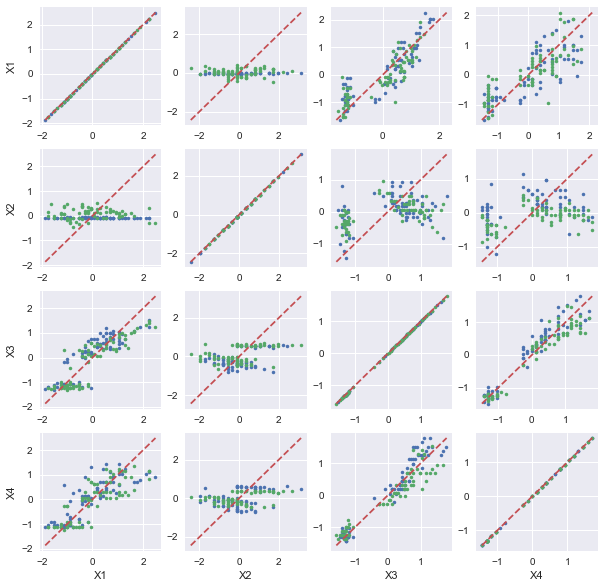

In [22]:
import matplotlib.pyplot as plt

def pairplot_cross_val(data, model=None, ax=None, **params):
    if ax is None:
        fig, ax = plt.subplots(data.shape[1], data.shape[1], figsize=params.get('figsize', (10,10)))
    if 'figsize' in params:
        del params["figsize"]
    if model is None:
        from sklearn.linear_model import LinearRegression
        model = LinearRegression
    
    df = scale(data)
    cor = numpy.corrcoef(df.T)
    for i in range(cor.shape[0]):
        xi = df[:, i:i+1]
        for j in range(cor.shape[1]):
            xj = df[:, j]
            mem = []
            xi_train, xi_test, xj_train, xj_test = train_test_split(xi, xj, train_size=0.5)
            mod = model(**params)            
            mod.fit(xi_train, xj_train)
            v = mod.predict(xi_test)
            mod = model(**params)            
            mod.fit(xi_test, xj_test)
            v2 = mod.predict(xi_train)
            ax[i,j].plot(xj_test, v, ".")
            ax[i,j].plot(xj_train, v2, ".")
            if j == 0:
                ax[i,j].set_ylabel(data.columns[i])
            if i == data.shape[1]-1:
                ax[i,j].set_xlabel(data.columns[j])
            mi = min(min(xj_test), min(v), min(xj_train), min(v2))
            ma = max(max(xj_test), max(v), max(xj_train), max(v2))
            ax[i,j].plot([mi, ma], [mi, ma], "--")
    return ax
            
ax = pairplot_cross_val(df)
ax

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020661F5EBE0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002066474B3C8>]], dtype=object)

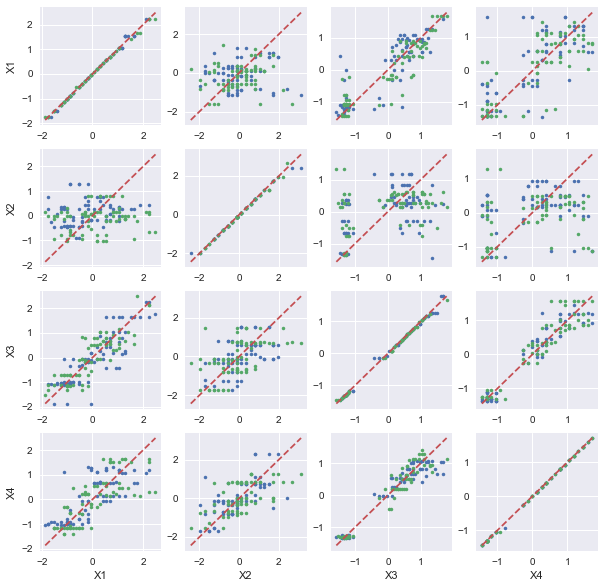

In [24]:
ax = pairplot_cross_val(df, model=DecisionTreeRegressor)
ax

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020664B9F198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000020665148710>]], dtype=object)

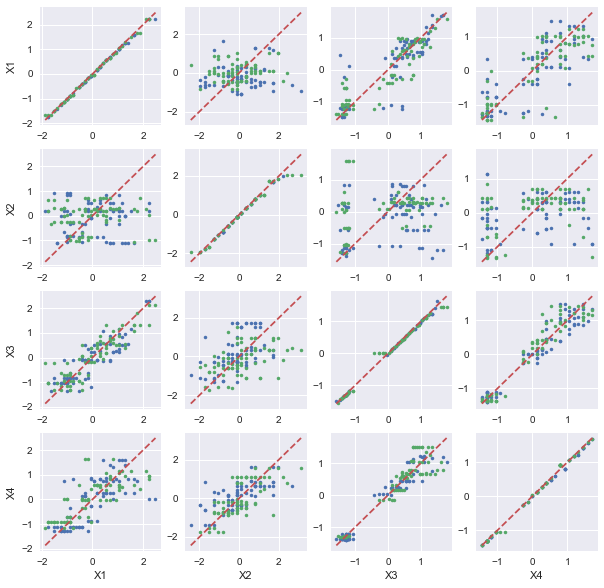

In [26]:
ax = pairplot_cross_val(df, model=RandomForestRegressor)
ax

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000206656595F8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000020665AF1400>]], dtype=object)

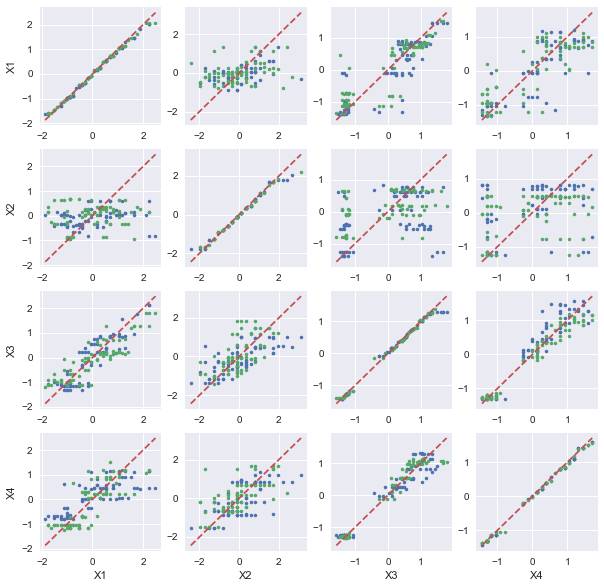

In [28]:
from sklearn.neighbors import KNeighborsRegressor
ax = pairplot_cross_val(df, model=KNeighborsRegressor)
ax

## Corrélations de variables catégorielles

C'est le problème épineux si on se restreint au linéaire. Cela n'a pas trop de sens d'affecter une valeur à chaque catégorie et la corrélation de deux variables binaires (des modalités) est toujours étrange car il n'y a que deux valeurs possibles.

$$cov(X,Y) = \mathbb{E}\left[(X - \mathbb{E}X)(Y - \mathbb{E}Y)\right] = \mathbb{E}(XY) - \mathbb{E}X\mathbb{E}Y = \mathbb{P}(X=1 \, et \, Y=1) - \mathbb{E}X\mathbb{E}Y$$

Dans le cas de variables binaires générées de modalités de la même variables catégorielles, le premier terme est toujours nul puisque les modalités sont exclusives et la corrélation est toujours négative.

In [30]:
import random
ex = numpy.zeros((100, 2))
for i in range(0, ex.shape[0]):
    h = random.randint(0, ex.shape[1]-1)
    ex[i, h] = 1
ex[:5]

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.]])

In [32]:
numpy.corrcoef(ex.T)

array([[ 1., -1.],
       [-1.,  1.]])

In [34]:
import random
ex = numpy.zeros((100, 3))
for i in range(0, ex.shape[0]):
    h = random.randint(0, ex.shape[1]-1)
    ex[i, h] = 1
ex[:5]
numpy.corrcoef(ex.T)

array([[ 1.        , -0.53594927, -0.52345457],
       [-0.53594927,  1.        , -0.4388013 ],
       [-0.52345457, -0.4388013 ,  1.        ]])

Supposons maintenant que nous avons deux variables catégorielles très proches :

* $X_1$ est une couleur rouge, bleu, gris.
* $X_2$ est une nuance rose, orange, cyan, magenta, blanc noir.

In [36]:
c1 = ["rouge", "bleu", "gris"]
c2 = ["rose" ,"orange" ,"cyan" ,"magenta", "blanc", "noir"]
ind = [random.randint(0, 2) for i in range(0, 100)]
x1 = [c1[i] for i in ind]
x2 = [c2[i*2 + random.randint(0,1)] for i in ind]
df = pandas.DataFrame(dict(X1=x1, X2=x2))
df.head()

,X1,X2
0,bleu,cyan
1,bleu,cyan
2,bleu,cyan
3,bleu,cyan
4,rouge,orange


On peut évidemment transformer en entier.

In [38]:
dummies = pandas.get_dummies(df)
dummies.head()

,X1_bleu,X1_gris,X1_rouge,X2_blanc,X2_cyan,X2_magenta,X2_noir,X2_orange,X2_rose
0,1,0,0,0,1,0,0,0,0
1,1,0,0,0,1,0,0,0,0
2,1,0,0,0,1,0,0,0,0
3,1,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,1,0


In [40]:
dummies.corr()

,X1_bleu,X1_gris,X1_rouge,X2_blanc,X2_cyan,X2_magenta,X2_noir,X2_orange,X2_rose
X1_bleu,1.000000,-0.514988,-0.481438,-0.361839,0.621872,0.644861,-0.283162,-0.294819,-0.317618
X1_gris,-0.514988,1.000000,-0.503382,0.702617,-0.320256,-0.332095,0.549841,-0.308257,-0.332095
X1_rouge,-0.481438,-0.503382,1.000000,-0.353685,-0.299392,-0.310460,-0.276780,0.612372,0.659728
X2_blanc,-0.361839,0.702617,-0.353685,1.000000,-0.225018,-0.233336,-0.208023,-0.216587,-0.233336
X2_cyan,0.621872,-0.320256,-0.299392,-0.225018,1.000000,-0.197518,-0.176090,-0.183340,-0.197518
X2_magenta,0.644861,-0.332095,-0.310460,-0.233336,-0.197518,1.000000,-0.182600,-0.190117,-0.204819
X2_noir,-0.283162,0.549841,-0.276780,-0.208023,-0.176090,-0.182600,1.000000,-0.169493,-0.182600
X2_orange,-0.294819,-0.308257,0.612372,-0.216587,-0.183340,-0.190117,-0.169493,1.000000,-0.190117
X2_rose,-0.317618,-0.332095,0.659728,-0.233336,-0.197518,-0.204819,-0.182600,-0.190117,1.000000


Ca ne dit pas grand-chose.

In [42]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df["X1e"] = enc.fit_transform(df["X1"])
df["X2e"] = enc.fit_transform(df["X2"])
df.head()

,X1,X2,X1e,X2e
0,bleu,cyan,0,1
1,bleu,cyan,0,1
2,bleu,cyan,0,1
3,bleu,cyan,0,1
4,rouge,orange,2,4


In [44]:
df.corr()

,X1e,X2e
X1e,1.000000,0.682362
X2e,0.682362,1.000000


Ca ne veut toujours pas dire grand-chose. Et si on change la première colonne en permutant les lables :

In [46]:
df["X1e"] = df["X1e"].apply(lambda i: (i+1)%3)
df.head()

,X1,X2,X1e,X2e
0,bleu,cyan,1,1
1,bleu,cyan,1,1
2,bleu,cyan,1,1
3,bleu,cyan,1,1
4,rouge,orange,0,4


In [48]:
df.corr()

,X1e,X2e
X1e,1.000000,-0.760491
X2e,-0.760491,1.000000


La corrélation linéaire sur des variables catégorielles n'a pas de sens. Essayons avec un arbre de décision. C'est le modèle adéquat pour ce type de valeur discrètes :

In [50]:
cor = correlation_cross_val(df[["X1e", "X2e"]], DecisionTreeRegressor)
cor

,X1e,X2e
X1e,1.0,0.836872
X2e,1.0,1.000000


Et si on permute le premier label :

In [52]:
df["X1e"] = df["X1e"].apply(lambda i: (i+1)%3)
correlation_cross_val(df[["X1e", "X2e"]], DecisionTreeRegressor)

,X1e,X2e
X1e,1.0,0.838118
X2e,1.0,1.000000


Même résultat qui s'interprète de la sorte :

* La variable *X1e* se déduit de *X2e* (car *cor(X2e, X1e) = 1*).
* La variable *X2e* et fortement lié à *X2e*.

La valeur numérique choisie pour représente la variable catégorielle n'a pas d'impact sur les résultats.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002066604E668>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000020665D8AEF0>]], dtype=object)

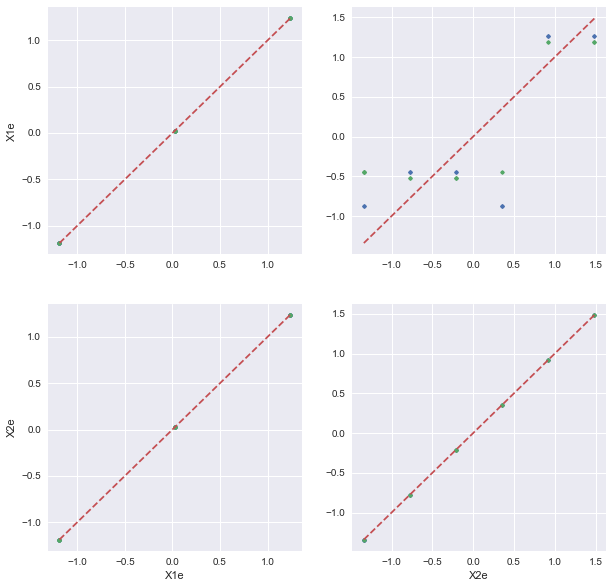

In [54]:
ax = pairplot_cross_val(df[["X1e", "X2e"]], model=DecisionTreeRegressor)
ax

Et sur un jeu de données plus complet.

In [56]:
from sklearn.datasets import load_boston
df = load_boston()
df = pandas.DataFrame(df.data, columns=df.feature_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [58]:
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.199458,0.404471,-0.055295,0.417521,-0.219940,0.350784,-0.377904,0.622029,0.579564,0.288250,-0.377365,0.452220
ZN,-0.199458,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.404471,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055295,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.417521,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219940,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.350784,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.377904,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.622029,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.579564,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


On dessine les 5 premières variables. On voit que la variable CHAS est binaire.

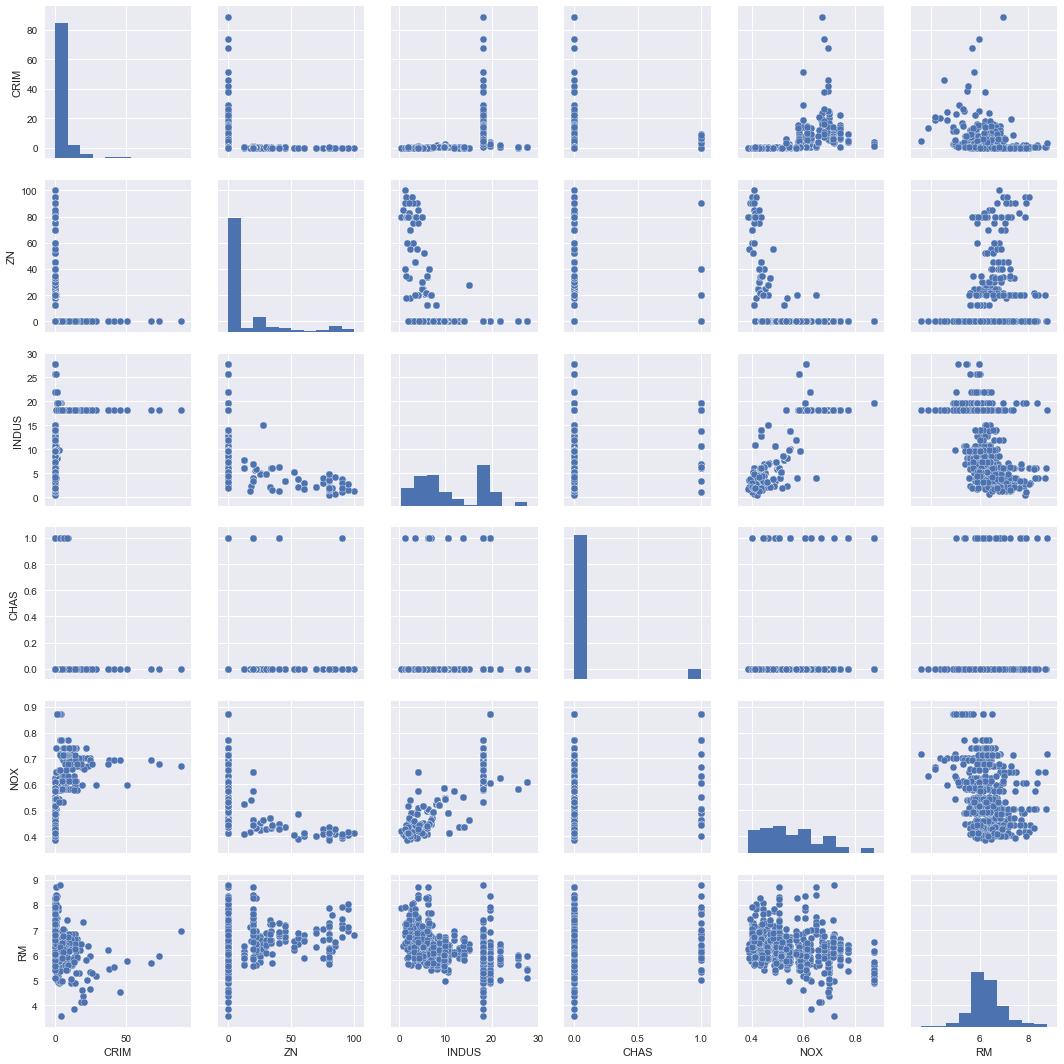

In [60]:
sns.pairplot(df[df.columns[:6]])

In [62]:
correlation_cross_val(df, DecisionTreeRegressor)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,0.990670,0.140737,0.327936,0.000000,0.606279,0.000000,0.072622,0.085130,0.899510,0.780584,0.000000,0.000000,0.000000
ZN,0.199940,0.999702,0.577690,0.141920,0.539266,0.262124,0.533003,0.731143,0.383212,0.417813,0.487811,0.207195,0.433514
INDUS,0.458998,0.803815,0.999980,0.163752,0.905410,0.453801,0.749529,0.917016,0.996059,0.961002,0.913780,0.513955,0.648945
CHAS,0.173358,0.093796,0.092832,1.000000,0.014656,0.206512,0.124100,0.071772,0.024297,0.030948,0.139595,0.054840,0.021675
NOX,0.584007,0.867829,0.967382,0.144909,0.999970,0.440389,0.769119,0.909041,0.965019,0.975504,0.904144,0.552884,0.705471
RM,0.000000,0.000000,0.000000,0.000000,0.000000,0.998565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063869
AGE,0.000000,0.082968,0.209076,0.000000,0.470090,0.000000,0.999929,0.419554,0.000000,0.000000,0.000000,0.000000,0.047927
DIS,0.064831,0.573808,0.530640,0.000000,0.687450,0.000000,0.586302,0.997147,0.000000,0.000000,0.000000,0.000000,0.063227
RAD,0.560410,0.297208,0.647800,0.119586,0.658344,0.211476,0.484610,0.517956,1.000000,0.917415,0.614670,0.502526,0.496228
TAX,0.690627,0.658026,0.940658,0.184198,0.858019,0.238057,0.715775,0.849303,0.992257,0.999969,0.852608,0.344430,0.600029


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020666A8A240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002066A07C588>]], dtype=object)

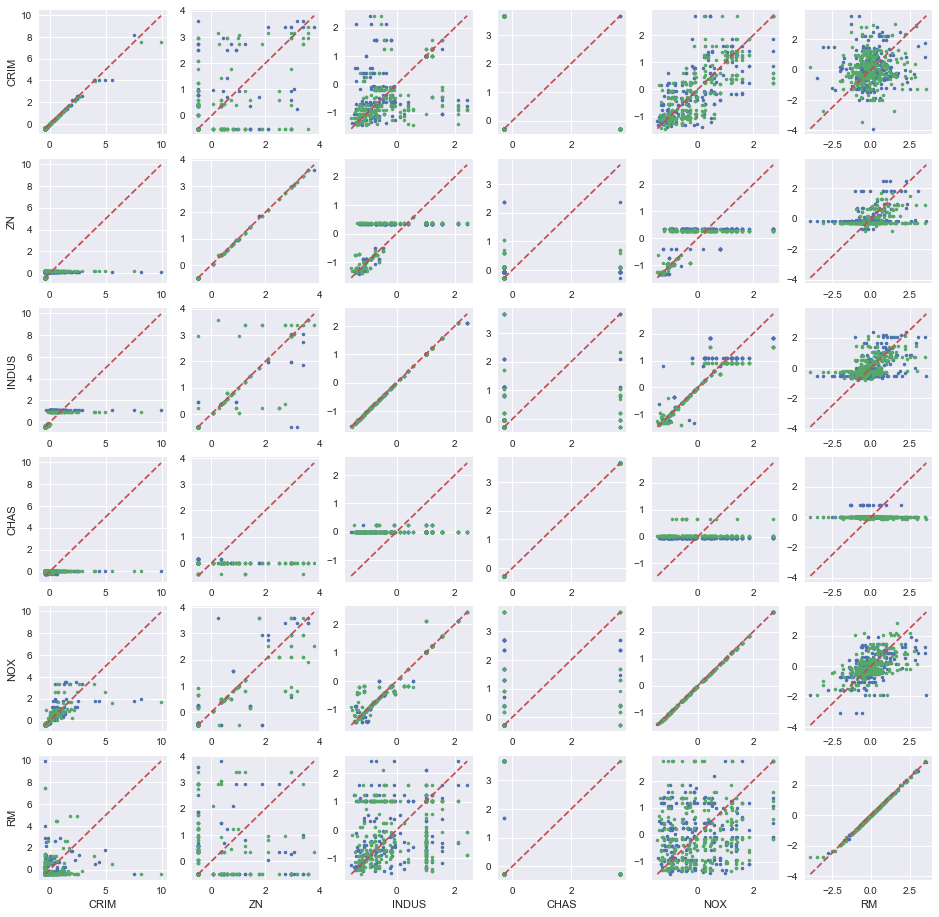

In [64]:
pairplot_cross_val(df[df.columns[:6]], model=DecisionTreeRegressor, figsize=(16,16))

On regarde en pariculier les variables TAX, RAD, PTRATIO.

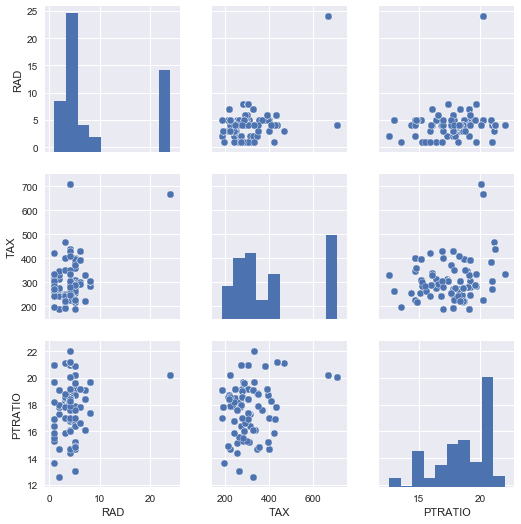

In [66]:
sns.pairplot(df[["RAD", "TAX", "PTRATIO"]])

In [68]:
df[["RAD", "TAX", "PTRATIO"]].corr()

,RAD,TAX,PTRATIO
RAD,1.000000,0.910228,0.464741
TAX,0.910228,1.000000,0.460853
PTRATIO,0.464741,0.460853,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020668D1A160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002066CDE8B00>]], dtype=object)

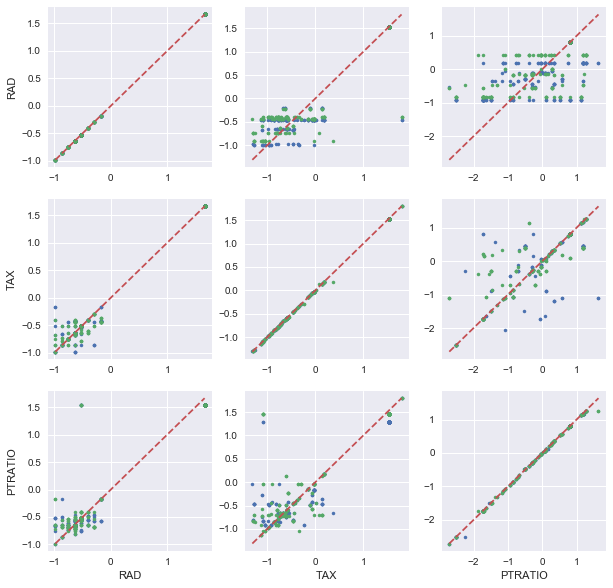

In [70]:
pairplot_cross_val(df[["RAD", "TAX", "PTRATIO"]], model=DecisionTreeRegressor)

In [72]:
correlation_cross_val(df[["RAD", "TAX", "PTRATIO"]], DecisionTreeRegressor)

,RAD,TAX,PTRATIO
RAD,1.000000,0.925543,0.617903
TAX,0.992144,0.999963,0.861104
PTRATIO,0.950673,0.912410,0.999621


## Maximal information coefficient

Cette approche est plutôt pragmatique mais peut se révéler coûteux en terme de calculs. Elle permet aussi de comprendre qu'un coefficient de corrélation dépend des hypothèses qu'on choisi pour les données. On peut toujours construire un coefficient de corrélation qui soit égal à 1 mais il correspond à toujours à un phénomène qu'on souhaite étudier. La corrélation linéaire recherche des relations linéaires. On peut chercher une relation polynomiale. Les arbres de décision recherche une corrélation construite à partir de fonction en escalier. Plus la relation a de degré de liberté, plus le coefficient a de chance de tendre vers 1, moins il a de chance d'être aussi élevé sur de nouvelles données.

Cela permet néanmoins de mieux comprendre les avantages et les inconvénients de métriques du type [MIC](https://en.wikipedia.org/wiki/Maximal_information_coefficient) ou *Maximal information coefficient*. Plus de détails sont disponibles dans cet article : [Equitability, mutual information, and the maximal information coefficient](https://arxiv.org/abs/1301.7745v1). Le module [minepy](http://minepy.readthedocs.io/en/latest/python.html) implémente cette métrique ainsi que d'autres qui poursuivent le même objectif. 

Je reproduis ici le code de l'exemple proposé par la librairie [minepy](http://minepy.readthedocs.io/en/latest/python.html#second-example) et j'y ajoute la corrélation proposée dans ce notebook ``DT`` pour *Decision Tree*.

In [74]:
%matplotlib inline

c:\Python36_x64\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


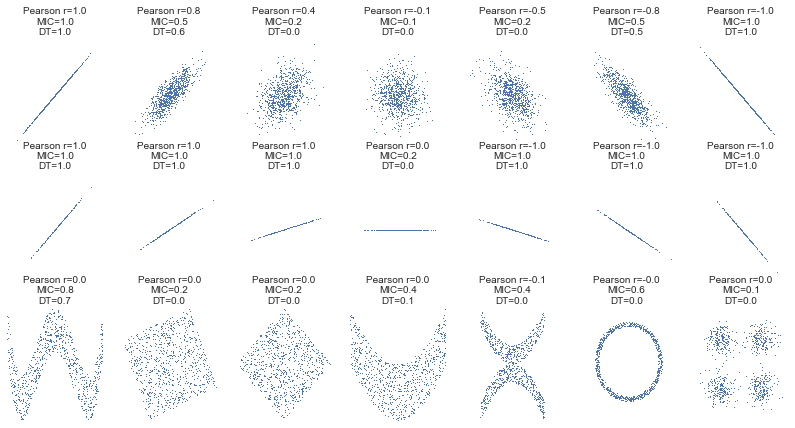

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from minepy import MINE


rs = np.random.RandomState(seed=0)

def mysubplot(x, y, numRows, numCols, plotNum,
              xlim=(-4, 4), ylim=(-4, 4)):

    r = np.around(np.corrcoef(x, y)[0, 1], 1)
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    mine.compute_score(x, y)
    mic = np.around(mine.mic(), 1)
    
    # début ajout
    df = pandas.DataFrame(dict(x=x, y=y))
    cor = correlation_cross_val(df, DecisionTreeRegressor)
    dt = max(cor.iloc[1,0], cor.iloc[0,1])
    
    ax = plt.subplot(numRows, numCols, plotNum,
                     xlim=xlim, ylim=ylim)
    ax.set_title('Pearson r=%.1f\nMIC=%.1f\nDT=%.1f' % (r, mic, dt),fontsize=10)
    ax.set_frame_on(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.plot(x, y, ',')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

def rotation(xy, t):
    return np.dot(xy, [[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])

def mvnormal(n=1000):
    cors = [1.0, 0.8, 0.4, 0.0, -0.4, -0.8, -1.0]
    for i, cor in enumerate(cors):
        cov = [[1, cor],[cor, 1]]
        xy = rs.multivariate_normal([0, 0], cov, n)
        mysubplot(xy[:, 0], xy[:, 1], 3, 7, i+1)

def rotnormal(n=1000):
    ts = [0, np.pi/12, np.pi/6, np.pi/4, np.pi/2-np.pi/6,
          np.pi/2-np.pi/12, np.pi/2]
    cov = [[1, 1],[1, 1]]
    xy = rs.multivariate_normal([0, 0], cov, n)
    for i, t in enumerate(ts):
        xy_r = rotation(xy, t)
        mysubplot(xy_r[:, 0], xy_r[:, 1], 3, 7, i+8)

def others(n=1000):
    x = rs.uniform(-1, 1, n)
    y = 4*(x**2-0.5)**2 + rs.uniform(-1, 1, n)/3
    mysubplot(x, y, 3, 7, 15, (-1, 1), (-1/3, 1+1/3))

    y = rs.uniform(-1, 1, n)
    xy = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
    xy = rotation(xy, -np.pi/8)
    lim = np.sqrt(2+np.sqrt(2)) / np.sqrt(2)
    mysubplot(xy[:, 0], xy[:, 1], 3, 7, 16, (-lim, lim), (-lim, lim))

    xy = rotation(xy, -np.pi/8)
    lim = np.sqrt(2)
    mysubplot(xy[:, 0], xy[:, 1], 3, 7, 17, (-lim, lim), (-lim, lim))

    y = 2*x**2 + rs.uniform(-1, 1, n)
    mysubplot(x, y, 3, 7, 18, (-1, 1), (-1, 3))

    y = (x**2 + rs.uniform(0, 0.5, n)) * \
        np.array([-1, 1])[rs.random_integers(0, 1, size=n)]
    mysubplot(x, y, 3, 7, 19, (-1.5, 1.5), (-1.5, 1.5))

    y = np.cos(x * np.pi) + rs.uniform(0, 1/8, n)
    x = np.sin(x * np.pi) + rs.uniform(0, 1/8, n)
    mysubplot(x, y, 3, 7, 20, (-1.5, 1.5), (-1.5, 1.5))

    xy1 = np.random.multivariate_normal([3, 3], [[1, 0], [0, 1]], int(n/4))
    xy2 = np.random.multivariate_normal([-3, 3], [[1, 0], [0, 1]], int(n/4))
    xy3 = np.random.multivariate_normal([-3, -3], [[1, 0], [0, 1]], int(n/4))
    xy4 = np.random.multivariate_normal([3, -3], [[1, 0], [0, 1]], int(n/4))
    xy = np.concatenate((xy1, xy2, xy3, xy4), axis=0)
    mysubplot(xy[:, 0], xy[:, 1], 3, 7, 21, (-7, 7), (-7, 7))

plt.figure(figsize=(14,7))
mvnormal(n=800)
rotnormal(n=200)
others(n=800)
# plt.tight_layout()
# plt.show()